In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

In [2]:


# Neural Network with Dropout
class HousingNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(HousingNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size // 2, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
            self.counter = 0


# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                epochs, early_stopping):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Early stopping check
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            model.load_state_dict(early_stopping.best_model)
            break
    
    return train_losses, val_losses


# Grid Search Function
def grid_search(X_train, y_train, X_val, y_val, param_grid, epochs=100, batch_size=32):
    results = []
    
    for params in param_grid:
        print(f"\nTesting parameters: {params}")
        
        # Create data loaders
        train_dataset = TensorDataset(X_train, y_train)
        val_dataset = TensorDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        # Initialize model
        model = HousingNN(
            input_size=X_train.shape[1],
            hidden_size=params['hidden_size'],
            dropout_rate=params['dropout_rate']
        )
        
        # Loss and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
        
        # Early stopping
        early_stopping = EarlyStopping(patience=10, verbose=False)
        
        # Train
        train_losses, val_losses = train_model(
            model, train_loader, val_loader, criterion, 
            optimizer, epochs, early_stopping
        )
        
        # Store results
        best_val_loss = min(val_losses)
        results.append({
            'params': params,
            'best_val_loss': best_val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses
        })
        
        print(f"Best validation loss: {best_val_loss:.4f}")
    
    return results

Loading California Housing dataset...

Starting Grid Search

Testing parameters: {'hidden_size': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001}
Epoch [10/100], Train Loss: 0.4295, Val Loss: 0.3681
Epoch [20/100], Train Loss: 0.3627, Val Loss: 0.3207
Epoch [30/100], Train Loss: 0.3379, Val Loss: 0.3067
Epoch [40/100], Train Loss: 0.3286, Val Loss: 0.2998
Epoch [50/100], Train Loss: 0.3228, Val Loss: 0.2920
Epoch [60/100], Train Loss: 0.3154, Val Loss: 0.2928
Epoch [70/100], Train Loss: 0.3166, Val Loss: 0.2874
Epoch [80/100], Train Loss: 0.3120, Val Loss: 0.2869
Early stopping triggered at epoch 82
Best validation loss: 0.2850

Testing parameters: {'hidden_size': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001}
Epoch [10/100], Train Loss: 0.3701, Val Loss: 0.3266
Epoch [20/100], Train Loss: 0.3239, Val Loss: 0.3074
Epoch [30/100], Train Loss: 0.3066, Val Loss: 0.2917
Epoch [40/100], Train Loss: 0.2986, Val Loss: 0.2839
Epoch [50/100], Train Loss: 0.2893, Val Loss: 0.2792
Epoch [60/10

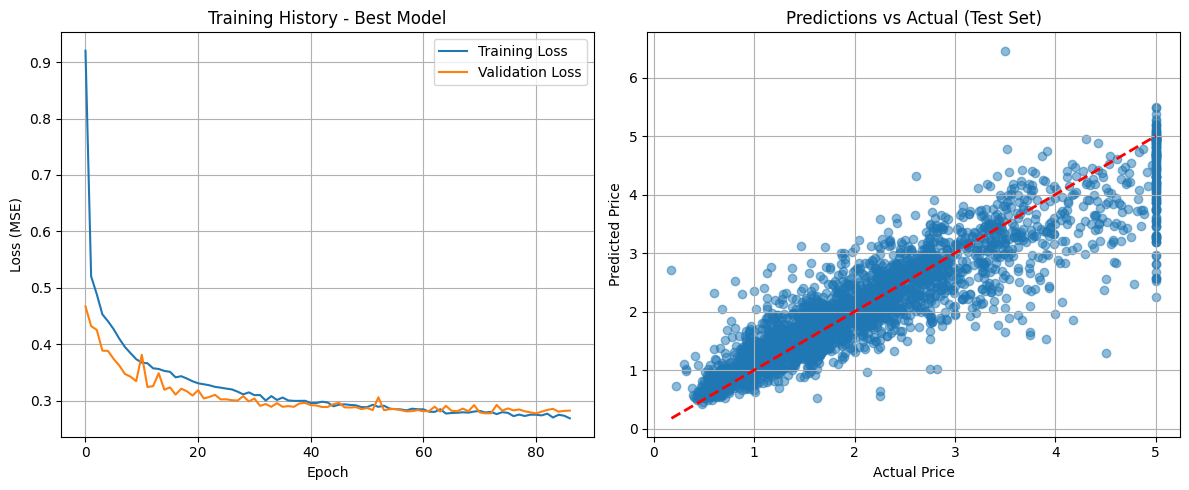

In [3]:
# Main execution
if __name__ == "__main__":
    # Load data
    print("Loading California Housing dataset...")
    housing = fetch_california_housing()
    X, y = housing.data, housing.target
    
    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    # Normalize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    # Convert to PyTorch tensors
    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train).reshape(-1, 1)
    X_val = torch.FloatTensor(X_val)
    y_val = torch.FloatTensor(y_val).reshape(-1, 1)
    X_test = torch.FloatTensor(X_test)
    y_test = torch.FloatTensor(y_test).reshape(-1, 1)
    
    # Define parameter grid
    param_grid = [
        {'hidden_size': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001},
        {'hidden_size': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001},
        {'hidden_size': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001},
        {'hidden_size': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0001},
    ]
    
    # Run grid search
    print("\n" + "="*50)
    print("Starting Grid Search")
    print("="*50)
    results = grid_search(X_train, y_train, X_val, y_val, param_grid, epochs=100)
    
    # Find best parameters
    best_result = min(results, key=lambda x: x['best_val_loss'])
    print("\n" + "="*50)
    print("Best parameters found:")
    print(best_result['params'])
    print(f"Best validation loss: {best_result['best_val_loss']:.4f}")
    print("="*50)
    
    # Train final model with best parameters
    print("\nTraining final model with best parameters...")
    best_params = best_result['params']
    
    final_model = HousingNN(
        input_size=X_train.shape[1],
        hidden_size=best_params['hidden_size'],
        dropout_rate=best_params['dropout_rate']
    )
    
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])
    early_stopping = EarlyStopping(patience=15, verbose=True)
    
    train_losses, val_losses = train_model(
        final_model, train_loader, val_loader, criterion, 
        optimizer, 150, early_stopping
    )
    
    # Evaluate on test set
    final_model.eval()
    with torch.no_grad():
        test_predictions = final_model(X_test)
        test_loss = criterion(test_predictions, y_test)
        print(f"\nTest Loss (MSE): {test_loss.item():.4f}")
        print(f"Test RMSE: {np.sqrt(test_loss.item()):.4f}")
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training History - Best Model')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.scatter(y_test.numpy(), test_predictions.numpy(), alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Predictions vs Actual (Test Set)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [4]:
final_model

HousingNN(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)